In [1]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(MAST)
source("/diskmnt/Projects/Users/Evan.p/scripts/Rscript/jupyter_support_functions.R")

Loading required package: SeuratObject

Loading required package: sp

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, saveRDS


Loading Seurat v5 beta version 
To maintain compatibility with previous workflows, new Seurat objects will use the previous object structure by default
To use new Seurat v5 assays: Please run: options(Seurat.object.assay.version = 'v5')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


In [2]:
stem_cell_genes = c('LGR5', 'ASCL2', 'OLFM4', 'PPP1R1B', 'RNF43', 'SATB2', 'SELENBP1',
                    'SLC12A2', 'SLC26A2', 'SMOC2', 'TCEA3', 'TSPAN8', 'UGT2B17',
                    'ATP1A1', 'CCDC14', 'CD44', 'CDHR1', 'CFTR', 'EPHB2', 'HNF4A',
                    'KLF4')

# Post GPU SCVI integration

## Tumor subset analysis

### load object

In [4]:
setwd('/diskmnt/Projects/MetNet_analysis_2/Colorectal/snMultiome/rds_objects/cell_types_subset/tumor')
tumor = readRDS('57_Integrated_normalized_mCRC_snRNA_noDB_v7_tumor_reINT.rds')
tumor

An object of class Seurat 
71822 features across 218537 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 2 layers present: counts, data
 1 other assay present: SCT
 7 dimensional reductions calculated: pca, umap.rna, integrated.scvi, mCRCv4_umap.scvi, mCRCv5_umap.scvi, mCRCv6_umap.scvi, tumor_umap.scvi

### Re-Clustering and doublets removal

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 218537
Number of edges: 2667365

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9276
Number of communities: 829
Elapsed time: 45 seconds


809 singletons identified. 20 final clusters.

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



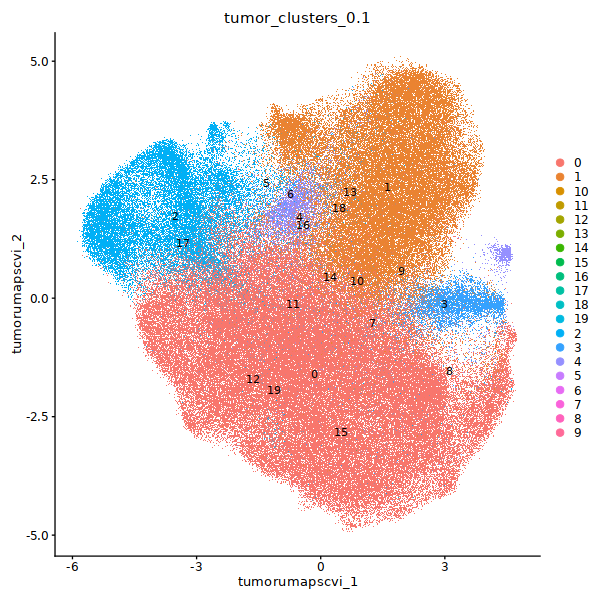

In [10]:
DefaultAssay(tumor) = 'SCT'
tumor <- FindClusters(tumor, resolution = 0.1, cluster.name = 'tumor_clusters_0.1', graph = 'RNA_snn')

set_size(6,6)
DimPlot(tumor, reduction = 'tumor_umap.scvi', group.by = 'tumor_clusters_0.1', label = TRUE)

In [11]:
table(tumor$tumor_clusters_0.1)


     0      1     10     11     12     13     14     15     16     17     18 
120134  59737      2      2      2      2      2      2      2      2      2 
    19      2      3      4      5      6      7      8      9 
     2  26948   6657   5031      2      2      2      2      2 

In [12]:
tumor <- tumor %>% subset(tumor_clusters_0.1 == '0' |
                          tumor_clusters_0.1 == '1' |
                          tumor_clusters_0.1 == '2' |
                          tumor_clusters_0.1 == '3' |
                          tumor_clusters_0.1 == '4' 
                         )

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



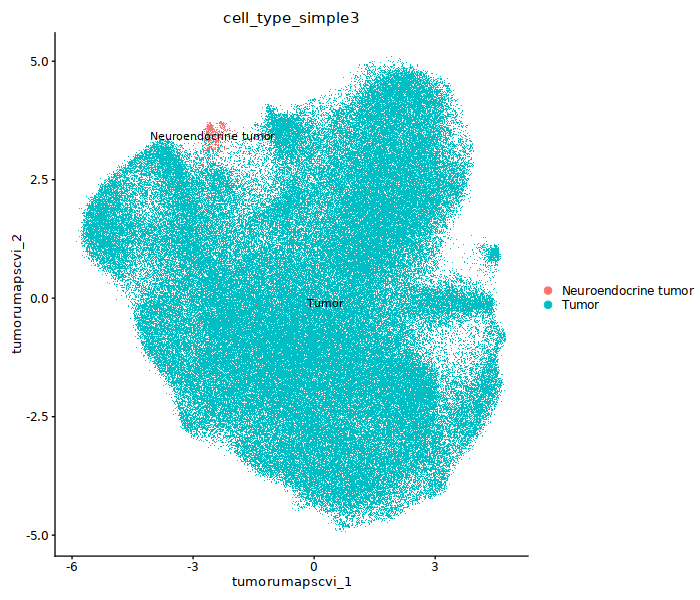

In [22]:
set_size(7,6)
DimPlot(tumor, reduction = 'tumor_umap.scvi', group.by = 'cell_type_simple3', label = TRUE)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



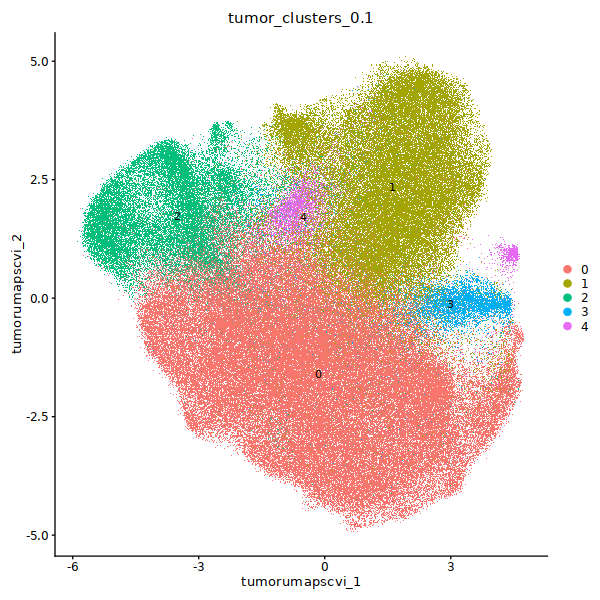

In [13]:
set_size(6,6)
DimPlot(tumor, reduction = 'tumor_umap.scvi', group.by = 'tumor_clusters_0.1', label = TRUE)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



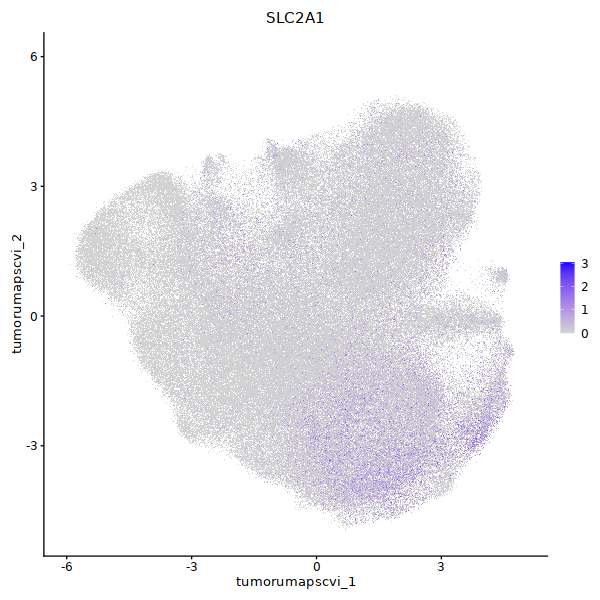

In [20]:
set_size(6,6)
FeaturePlot(tumor, features = 'SLC2A1', reduction = 'tumor_umap.scvi')

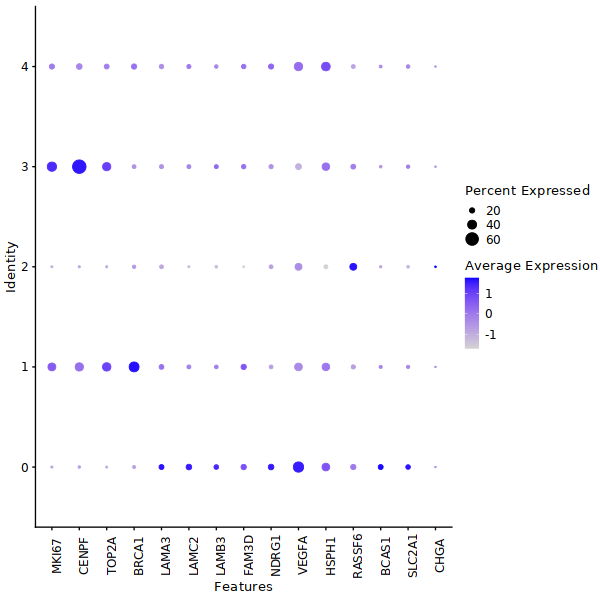

In [16]:
set_size(6,6)
Idents(tumor)<- 'tumor_clusters_0.1'
DotPlot(tumor, features = c("MKI67", "CENPF", "TOP2A", "BRCA1", "LAMA3", "LAMC2", "LAMB3",
                            "FAM3D", "NDRG1", "VEGFA", "HSPH1",'RASSF6', 'BCAS1', 'SLC2A1', 'CHGA'))+ 
theme(axis.text.x = element_text(angle = 90),  panel.background = element_rect(fill = "white"), plot.background = element_rect(fill = "white"))

In [23]:
Idents(tumor) = "tumor_clusters_0.1"
tumor = FindSubCluster(object = tumor,
                       cluster = '4',
                       graph.name = 'RNA_snn',
                       subcluster.name = "tumor_clusters_sub4",
                       resolution = 0.1,
                       algorithm = 1
                      )
unique(tumor$tumor_clusters_sub4)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5031
Number of edges: 101153

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9367
Number of communities: 3
Elapsed time: 0 seconds


[1] "0"   "1"   "2"   "3"   "4_0" "4_1" "4_2"

In [25]:
table(tumor$tumor_clusters_sub4)


     0      1      2      3    4_0    4_1    4_2 
120134  59737  26948   6657   3565   1464      2 

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



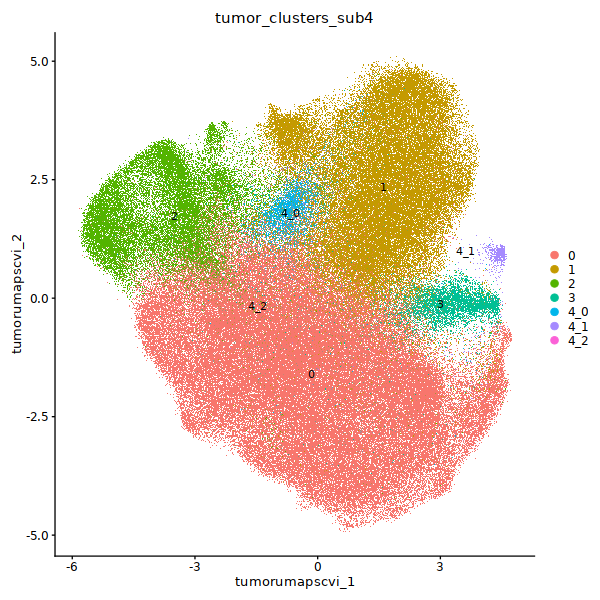

In [24]:
set_size(6,6)
DimPlot(tumor, reduction = 'tumor_umap.scvi', group.by = 'tumor_clusters_sub4', label = TRUE)

In [26]:
Idents(tumor) = "tumor_clusters_sub4"
tumor = FindSubCluster(object = tumor,
                       cluster = '2',
                       graph.name = 'RNA_snn',
                       subcluster.name = "tumor_clusters_sub4_2",
                       resolution = 0.1,
                       algorithm = 1
                      )
unique(tumor$tumor_clusters_sub4_2)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 26948
Number of edges: 386570

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9259
Number of communities: 3
Elapsed time: 2 seconds


[1] "0"   "1"   "2_0" "3"   "4_0" "2_1" "2_2" "4_1" "4_2"

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



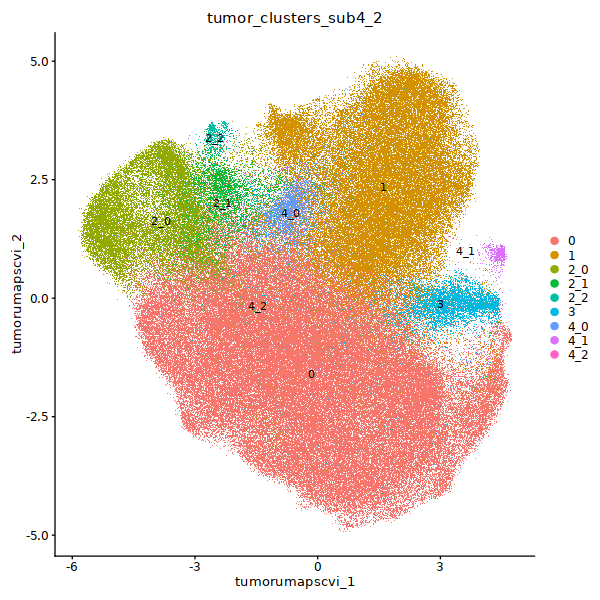

In [27]:
set_size(6,6)
DimPlot(tumor, reduction = 'tumor_umap.scvi', group.by = 'tumor_clusters_sub4_2', label = TRUE)

In [28]:
Idents(tumor) = "tumor_clusters_sub4_2"
tumor = FindSubCluster(object = tumor,
                       cluster = '0',
                       graph.name = 'RNA_snn',
                       subcluster.name = "tumor_clusters_sub4_2_0",
                       resolution = 0.1,
                       algorithm = 1
                      )
unique(tumor$tumor_clusters_sub4_2_0)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 120134
Number of edges: 1267531

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9124
Number of communities: 5
Elapsed time: 13 seconds


[1] "0_4" "1"   "0_0" "2_0" "0_1" "3"   "4_0" "2_1" "0_3" "2_2" "4_1" "0_2"
[13] "4_2"

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



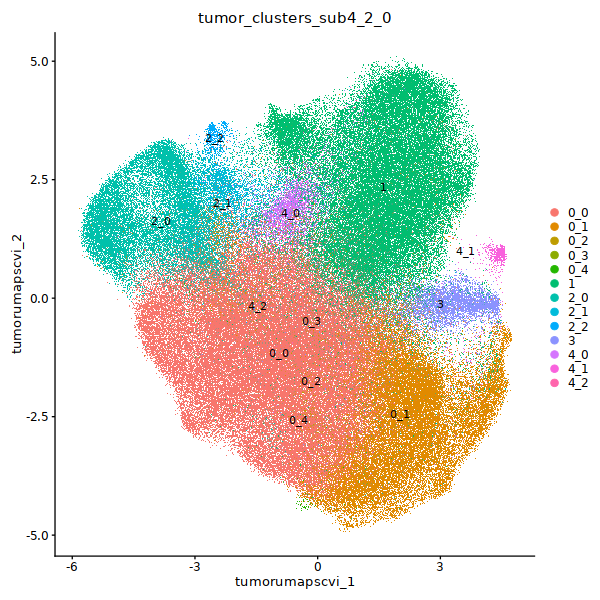

In [29]:
set_size(6,6)
DimPlot(tumor, reduction = 'tumor_umap.scvi', group.by = 'tumor_clusters_sub4_2_0', label = TRUE)

In [30]:
Idents(tumor) = "tumor_clusters_sub4_2_0"
tumor = FindSubCluster(object = tumor,
                       cluster = '1',
                       graph.name = 'RNA_snn',
                       subcluster.name = "tumor_clusters_0.1_sub",
                       resolution = 0.1,
                       algorithm = 1
                      )
unique(tumor$tumor_clusters_0.1_sub)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 59737
Number of edges: 706106

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9209
Number of communities: 4
Elapsed time: 7 seconds


[1] "0_4" "1_0" "1_1" "0_0" "2_0" "0_1" "3"   "1_3" "4_0" "2_1" "1_2" "0_3"
[13] "2_2" "4_1" "0_2" "4_2"

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



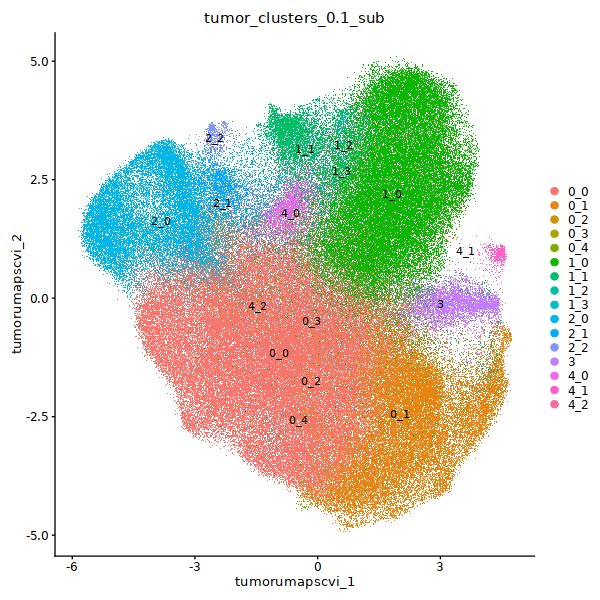

In [31]:
set_size(6,6)
DimPlot(tumor, reduction = 'tumor_umap.scvi', group.by = 'tumor_clusters_0.1_sub', label = TRUE)

In [32]:
table(tumor$tumor_clusters_0.1_sub)


  0_0   0_1   0_2   0_3   0_4   1_0   1_1   1_2   1_3   2_0   2_1   2_2     3 
81034 37408  1173   385   134 49872  8294  1283   288 21436  4768   744  6657 
  4_0   4_1   4_2 
 3565  1464     2 

In [34]:
tumor@meta.data <- tumor@meta.data %>% 
                   mutate(tumor_cluster = case_when(
                       tumor_clusters_0.1_sub == '0_0' ~ 0,
                       tumor_clusters_0.1_sub == '0_2' ~ 0,
                       tumor_clusters_0.1_sub == '0_3' ~ 0,
                       tumor_clusters_0.1_sub == '0_4' ~ 0,
                       tumor_clusters_0.1_sub == '0_1' ~ 1,
                       tumor_clusters_0.1_sub == '1_0' ~ 2,
                       tumor_clusters_0.1_sub == '1_2' ~ 2,
                       tumor_clusters_0.1_sub == '1_3' ~ 2,
                       tumor_clusters_0.1_sub == '1_1' ~ 3,
                       tumor_clusters_0.1_sub == '2_0' ~ 4,
                       tumor_clusters_0.1_sub == '2_1' ~ 4,
                       tumor_clusters_0.1_sub == '2_2' ~ 5,
                       tumor_clusters_0.1_sub == '3' ~ 6,
                       tumor_clusters_0.1_sub == '4_0' ~ 7,
                       tumor_clusters_0.1_sub == '4_2' ~ 7,
                       tumor_clusters_0.1_sub == '4_1' ~ 8
                   ))

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



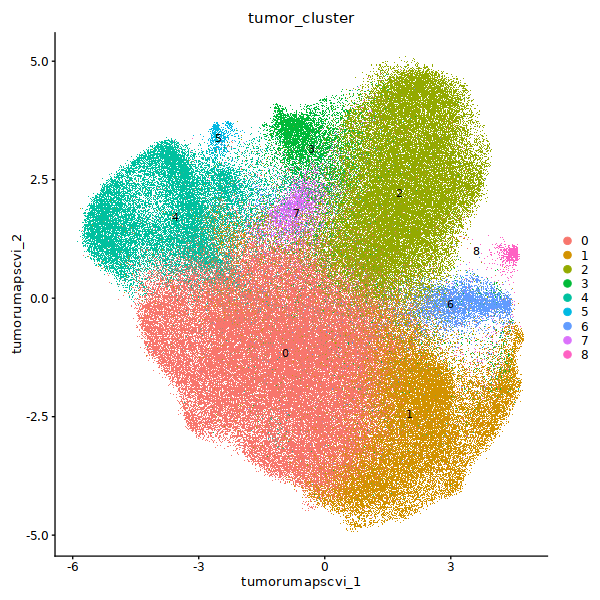

In [35]:
set_size(6,6)
DimPlot(tumor, reduction = 'tumor_umap.scvi', group.by = 'tumor_cluster', label = TRUE)

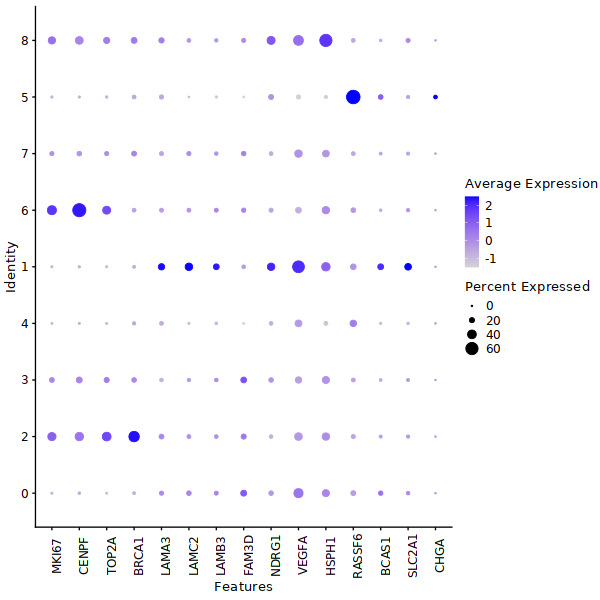

In [36]:
set_size(6,6)
Idents(tumor)<- 'tumor_cluster'
DotPlot(tumor, features = c("MKI67", "CENPF", "TOP2A", "BRCA1", "LAMA3", "LAMC2", "LAMB3",
                            "FAM3D", "NDRG1", "VEGFA", "HSPH1",'RASSF6', 'BCAS1', 'SLC2A1', 'CHGA'))+ 
theme(axis.text.x = element_text(angle = 90),  panel.background = element_rect(fill = "white"), plot.background = element_rect(fill = "white"))

### Tumor cluster DEG

In [40]:
Idents(tumor) = "tumor_cluster"
tumor_markers = FindAllMarkers(tumor, 
                               min.pct=0.1, 
                               logfc.threshold=0.5, 
                               only.pos = TRUE, 
                               return.thresh = 0.01,
                               test.use = 'MAST'
                              )

Calculating cluster 0

Warning message in new_with_repaired_slots(classname = method, design = colData(sca), :
“Dropping illegal slot(s) norm.method for class BayesGLMlike.  
                    This likely indicates a bug in an upstream package.”

 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>----------------

In [45]:
write.csv(tumor_markers, "mCRC_tumor_mast_deg.csv", row.names = TRUE)

In [46]:
tumor_markers %>% filter(gene == 'MKI67')


p_val        avg_log2FC pct.1 pct.2 p_val_adj    cluster gene 
MKI67  0.000000e+00 1.7793775  0.368 0.061 0.000000e+00 2       MKI67
MKI671 0.000000e+00 1.8318171  0.418 0.124 0.000000e+00 6       MKI67
MKI672 7.741965e-74 0.8614572  0.317 0.132 2.726797e-69 8       MKI67

In [ ]:
# cluster 7 with T cell genes, favored doublets with T cells
# cluster 8 with abundant of mito genes, favored dead cells

In [121]:
tumor2 <- tumor %>% subset(tumor_cluster != '7' &
                           tumor_cluster != '8'
                          ) 

In [122]:
setwd('/diskmnt/Projects/MetNet_analysis_2/Colorectal/snMultiome/rds_objects/cell_types_subset/tumor')
saveRDS(tumor2, '57_Integrated_normalized_mCRC_snRNA_noDB_v7_tumor_clean1.rds') 

## Epithelial subset analysis

### load object

In [47]:
setwd('/diskmnt/Projects/MetNet_analysis_2/Colorectal/snMultiome/rds_objects/cell_types_subset/epithelial')
epithelial = readRDS('57_Integrated_normalized_mCRC_snRNA_noDB_v7_epithelial_reINT.rds')
epithelial

An object of class Seurat 
71822 features across 239854 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 2 layers present: counts, data
 1 other assay present: SCT
 7 dimensional reductions calculated: pca, umap.rna, integrated.scvi, mCRCv4_umap.scvi, mCRCv5_umap.scvi, mCRCv6_umap.scvi, epithelial_umap.scvi

### Re-clustering and doublet removal

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 239854
Number of edges: 3304694

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9406
Number of communities: 790
Elapsed time: 56 seconds


776 singletons identified. 14 final clusters.

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



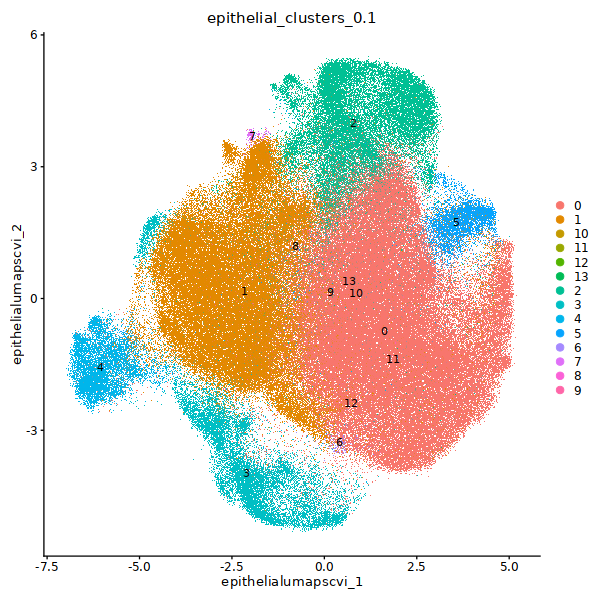

In [50]:
DefaultAssay(epithelial) = 'SCT'
epithelial <- FindClusters(epithelial, resolution = 0.1, cluster.name = 'epithelial_clusters_0.1', graph = 'RNA_snn')

set_size(6,6)
DimPlot(epithelial, reduction = 'epithelial_umap.scvi', group.by = 'epithelial_clusters_0.1', label = TRUE)

In [52]:
tumor.metadata = tumor@meta.data

epithelial<- AddMetaData(object = epithelial, metadata = tumor.metadata, col.name = 'tumor_cluster')

In [126]:
colnames(epithelial@meta.data)

[1] "orig.ident"                    "Patient_ID"                   
 [3] "nCount_RNA"                    "nFeature_RNA"                 
 [5] "percent.mito"                  "nCount_SCT"                   
 [7] "nFeature_SCT"                  "seurat_clusters"              
 [9] "S.Score"                       "G2M.Score"                    
[11] "Phase"                         "SCT_snn_res.2"                
[13] "cell_type_RNA"                 "cell_type_RNA_simple"         
[15] "Age"                           "Sex"                          
[17] "Site_of_Origin"                "Tissue_Type"                  
[19] "Primary_Side"                  "MSI"                          
[21] "MSI_score"                     "Tx_in_6mo"                    
[23] "scrublet_doublet"              "DF_doublet"                   
[25] "cell_type_integrated"          "cell_type_simple"             
[27] "cell_type_integrated2"         "cell_type_simple2"            
[29] "mCRCv5_clusters_2"             "mCRCv6_clusters_0.2"          
[31] "mCRCv6_clusters_0.4"           "mCRCv6_clusters_0.6"          
[33] "mCRCv6_clusters_0.8"           "mCRCv6_clusters_1"            
[35] "mCRCv6_clusters_1.2"           "mCRCv6_clusters_1.4"          
[37] "mCRCv6_clusters_1.6"           "mCRCv6_clusters_1.8"          
[39] "mCRCv6_clusters_2"             "cell_type_simple3"            
[41] "mCRCv6_clusters_2_sub65_16"    "mCRCv6_clusters_2_sub65_16_34"
[43] "tumor_in_normal"               "cell_type_integrated3"        
[45] "epithelial_clusters_0.2"       "epithelial_clusters_0.4"      
[47] "epithelial_clusters_0.6"       "epithelial_clusters_0.8"      
[49] "epithelial_clusters_1"         "epithelial_clusters_1.2"      
[51] "epithelial_clusters_1.4"       "epithelial_clusters_1.6"      
[53] "epithelial_clusters_1.8"       "epithelial_clusters_2"        
[55] "epithelial_clusters_0.1"       "tumor_cluster"

In [132]:
epithelial@meta.data <- epithelial@meta.data %>% 
  mutate(epithelial_cluster = if_else(
    !is.na(tumor_cluster), 
    as.character(tumor_cluster), 
    cell_type_simple3
  ))

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



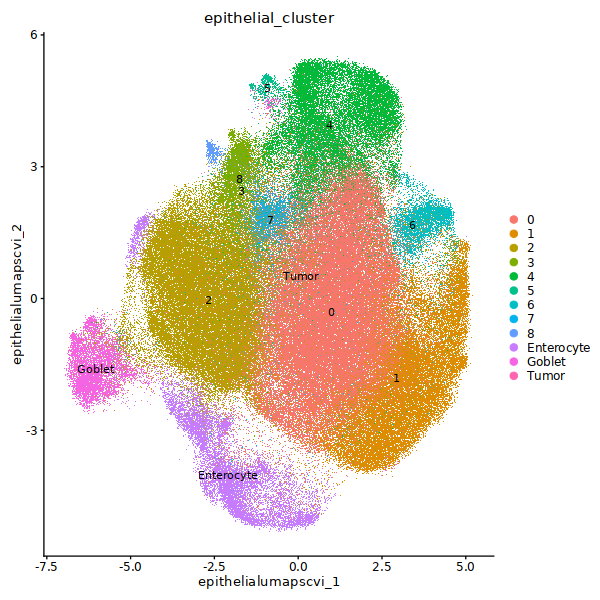

In [133]:
set_size(6,6)
DimPlot(epithelial, reduction = 'epithelial_umap.scvi', group.by = 'epithelial_cluster', label = TRUE)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



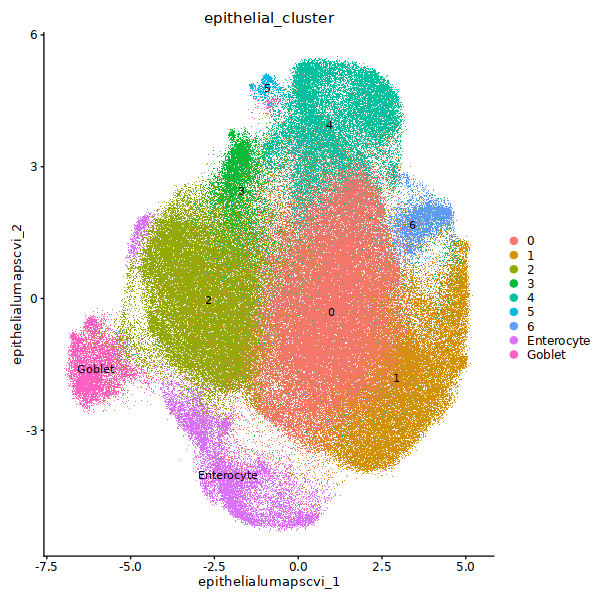

In [135]:
epithelial2 = epithelial %>% subset(epithelial_cluster != '7' &
                                    epithelial_cluster != '8' &
                                    epithelial_cluster != 'Tumor'
                                   )

set_size(6,6)
DimPlot(epithelial2, reduction = 'epithelial_umap.scvi', group.by = 'epithelial_cluster', label = TRUE)

In [137]:
Idents(epithelial2) = "epithelial_cluster"
epithelial2 = FindSubCluster(object = epithelial2,
                       cluster = 'Enterocyte',
                       graph.name = 'RNA_snn',
                       subcluster.name = "epithelial_cluster_esub",
                       resolution = 0.1,
                       algorithm = 1
                      )
unique(epithelial2$epithelial_cluster_gsub)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 13616
Number of edges: 357217

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9310
Number of communities: 152
Elapsed time: 1 seconds


145 singletons identified. 7 final clusters.



[1] "0"            "2"            "3"            "4"            "1"           
 [6] "6"            "5"            "Goblet"       "Enterocyte_1" "Enterocyte_0"
[11] "Enterocyte_2" "Enterocyte_4" "Enterocyte_3" "Enterocyte_5" "Enterocyte_6"

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



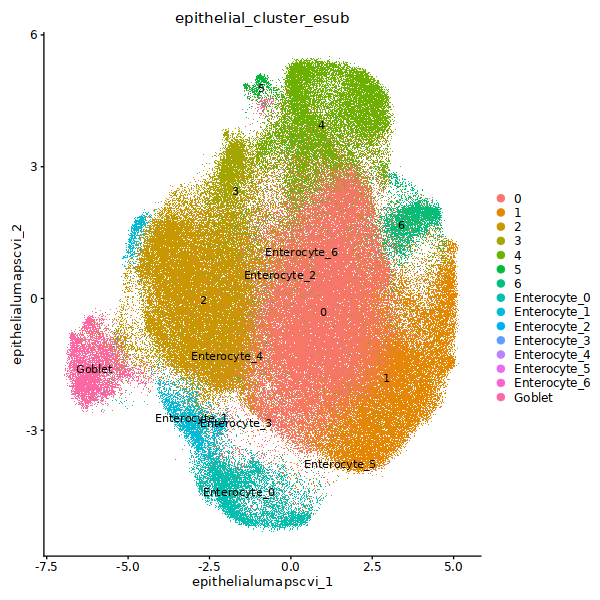

In [138]:
set_size(6,6)
DimPlot(epithelial2, reduction = 'epithelial_umap.scvi', group.by = 'epithelial_cluster_esub', label = TRUE)

In [139]:
table(epithelial2$epithelial_cluster_esub)


           0            1            2            3            4            5 
       82726        37408        51443         8294        26204          744 
           6 Enterocyte_0 Enterocyte_1 Enterocyte_2 Enterocyte_3 Enterocyte_4 
        6657         8538         5068            2            2            2 
Enterocyte_5 Enterocyte_6       Goblet 
           2            2         7701 

In [140]:
Idents(epithelial2) = "epithelial_cluster_esub"
epithelial2 = FindSubCluster(object = epithelial2,
                       cluster = 'Goblet',
                       graph.name = 'RNA_snn',
                       subcluster.name = "epithelial_cluster_egsub",
                       resolution = 0.1,
                       algorithm = 1
                      )
unique(epithelial2$epithelial_cluster_egsub)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7701
Number of edges: 188774

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9179
Number of communities: 282
Elapsed time: 0 seconds


260 singletons identified. 22 final clusters.



[1] "0"            "2"            "3"            "4"            "1"           
 [6] "6"            "5"            "Goblet_0"     "Goblet_1"     "Goblet_18"   
[11] "Goblet_2"     "Enterocyte_1" "Enterocyte_0" "Goblet_7"     "Goblet_9"    
[16] "Goblet_4"     "Enterocyte_2" "Goblet_8"     "Goblet_20"    "Enterocyte_4"
[21] "Goblet_5"     "Goblet_10"    "Goblet_11"    "Goblet_14"    "Goblet_12"   
[26] "Enterocyte_3" "Goblet_13"    "Goblet_15"    "Goblet_3"     "Enterocyte_5"
[31] "Goblet_16"    "Goblet_17"    "Goblet_6"     "Goblet_19"    "Goblet_21"   
[36] "Enterocyte_6"

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`




           0            1            2            3            4            5 
       82726        37408        51443         8294        26204          744 
           6 Enterocyte_0 Enterocyte_1 Enterocyte_2 Enterocyte_3 Enterocyte_4 
        6657         8538         5068            2            2            2 
Enterocyte_5 Enterocyte_6     Goblet_0     Goblet_1    Goblet_10    Goblet_11 
           2            2         4270         2432            2            2 
   Goblet_12    Goblet_13    Goblet_14    Goblet_15    Goblet_16    Goblet_17 
           2            2            2            2            2            2 
   Goblet_18    Goblet_19     Goblet_2    Goblet_20    Goblet_21     Goblet_3 
           2            2          954            2            2            6 
    Goblet_4     Goblet_5     Goblet_6     Goblet_7     Goblet_8     Goblet_9 
           3            3            3            2            2            2 

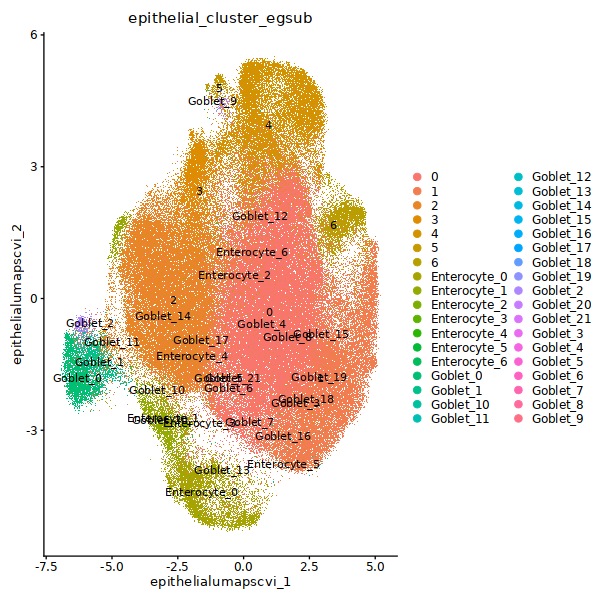

In [141]:
set_size(6,6)
DimPlot(epithelial2, reduction = 'epithelial_umap.scvi', group.by = 'epithelial_cluster_egsub', label = TRUE)

table(epithelial2$epithelial_cluster_egsub)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



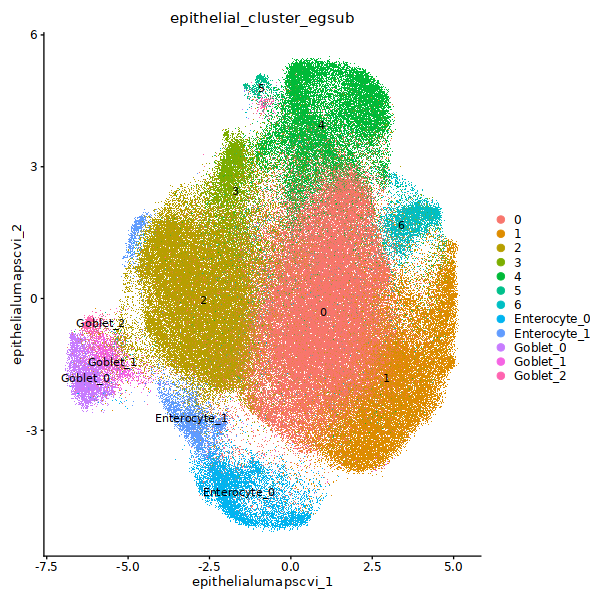

In [143]:
epithelial2 <- epithelial2 %>% subset(epithelial_cluster_egsub == '0' |
                                      epithelial_cluster_egsub == '1' |
                                      epithelial_cluster_egsub == '2' |
                                      epithelial_cluster_egsub == '3' |
                                      epithelial_cluster_egsub == '4' |
                                      epithelial_cluster_egsub == '5' |
                                      epithelial_cluster_egsub == '6' |
                                      epithelial_cluster_egsub == 'Enterocyte_0' |
                                      epithelial_cluster_egsub == 'Enterocyte_1' |
                                      epithelial_cluster_egsub == 'Goblet_0' |
                                      epithelial_cluster_egsub == 'Goblet_1' |
                                      epithelial_cluster_egsub == 'Goblet_2'
                                     )

set_size(6,6)
DimPlot(epithelial2, reduction = 'epithelial_umap.scvi', group.by = 'epithelial_cluster_egsub', label = TRUE)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5068
Number of edges: 122426

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9216
Number of communities: 148
Elapsed time: 0 seconds


145 singletons identified. 3 final clusters.



[1] "0"              "2"              "3"              "4"             
 [5] "1"              "6"              "5"              "Goblet_0"      
 [9] "Goblet_1"       "Goblet_2"       "Enterocyte_1_0" "Enterocyte_0"  
[13] "Enterocyte_1_1" "Enterocyte_1_2"

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



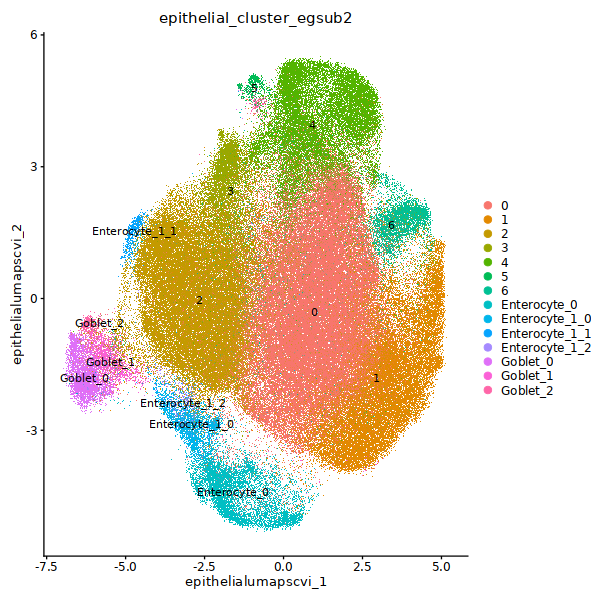

In [145]:
Idents(epithelial2) = "epithelial_cluster_egsub"
epithelial2 = FindSubCluster(object = epithelial2,
                       cluster = 'Enterocyte_1',
                       graph.name = 'RNA_snn',
                       subcluster.name = "epithelial_cluster_egsub2",
                       resolution = 0.1,
                       algorithm = 1
                      )
unique(epithelial2$epithelial_cluster_egsub2)

set_size(6,6)
DimPlot(epithelial2, reduction = 'epithelial_umap.scvi', group.by = 'epithelial_cluster_egsub2', label = TRUE)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 954
Number of edges: 19580

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9275
Number of communities: 262
Elapsed time: 0 seconds


260 singletons identified. 2 final clusters.



[1] "0"              "2"              "3"              "4"             
 [5] "1"              "6"              "5"              "Goblet_0"      
 [9] "Goblet_1"       "Goblet_2_0"     "Enterocyte_1_0" "Enterocyte_0"  
[13] "Goblet_2_1"     "Enterocyte_1_1" "Enterocyte_1_2"

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



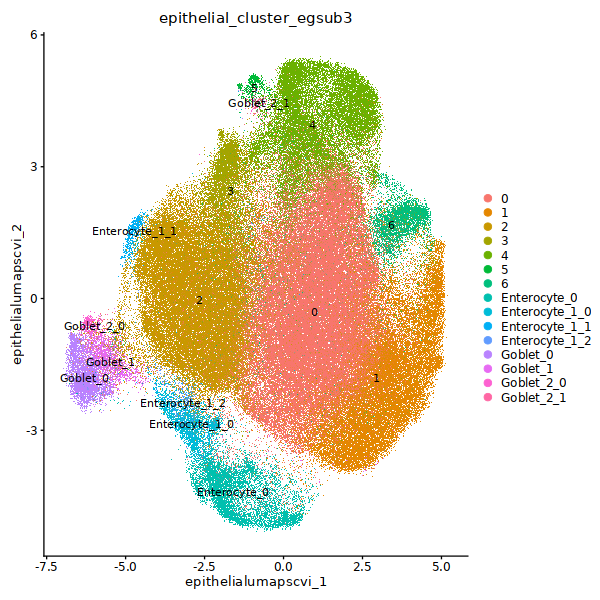

In [146]:
Idents(epithelial2) = "epithelial_cluster_egsub2"
epithelial2 = FindSubCluster(object = epithelial2,
                       cluster = 'Goblet_2',
                       graph.name = 'RNA_snn',
                       subcluster.name = "epithelial_cluster_egsub3",
                       resolution = 0.1,
                       algorithm = 1
                      )
unique(epithelial2$epithelial_cluster_egsub3)

set_size(6,6)
DimPlot(epithelial2, reduction = 'epithelial_umap.scvi', group.by = 'epithelial_cluster_egsub3', label = TRUE)

In [148]:
setwd('/diskmnt/Projects/MetNet_analysis_2/Colorectal/snMultiome/rds_objects/cell_types_subset/epithelial')
saveRDS(epithelial2, '57_Integrated_normalized_mCRC_snRNA_noDB_v7_epithelial_clean1.rds') 

### DEG

In [149]:
Idents(epithelial2) = "epithelial_cluster_egsub3"
epithelial2_markers = FindAllMarkers(epithelial2, 
                                     min.pct=0.1, 
                                     logfc.threshold=0.5, 
                                     only.pos = TRUE, 
                                     return.thresh = 0.01,
                                     test.use = 'MAST'
                                    )

setwd('/diskmnt/Projects/MetNet_analysis_2/Colorectal/snMultiome/rds_objects/cell_types_subset/epithelial')
write.csv(epithelial2_markers, "mCRC_epithelial_mast_deg.csv", row.names = TRUE)

Calculating cluster 0

Warning message in new_with_repaired_slots(classname = method, design = colData(sca), :
“Dropping illegal slot(s) norm.method for class BayesGLMlike.  
                    This likely indicates a bug in an upstream package.”

 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>---------------

In [151]:
epithelial_cluster = epithelial2@meta.data %>% select('epithelial_cluster_egsub3')
write.csv(epithelial_cluster,  "mCRC_epithelial_cluster.metadata.csv", row.names = TRUE)

### Feature Plots of intestine markers

In [5]:
setwd('/diskmnt/Projects/MetNet_analysis_2/Colorectal/snMultiome/rds_objects/cell_types_subset/epithelial')
epithelial2 = readRDS('57_Integrated_normalized_mCRC_snRNA_noDB_v7_epithelial_clean1.rds') 

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



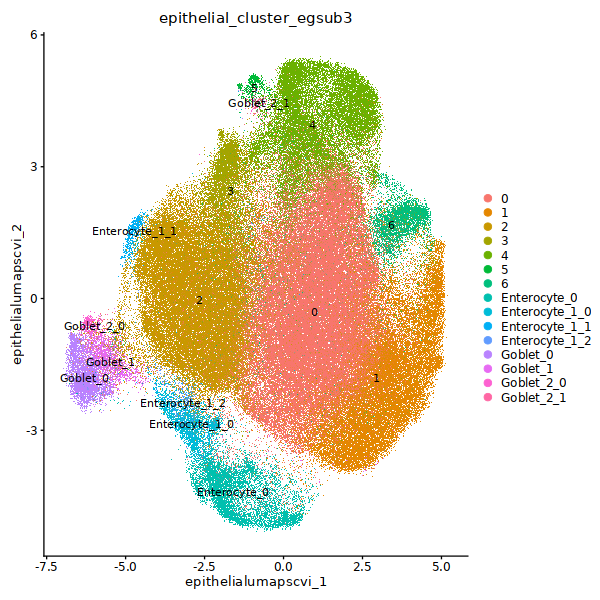

In [6]:
set_size(6,6)
DimPlot(epithelial2, reduction = 'epithelial_umap.scvi', group.by = 'epithelial_cluster_egsub3', label = TRUE)

In [9]:
unique(epithelial2$orig.ident)

[1] "HT112C1-T1"                 "HT225C1-Th1"               
 [3] "HT230C1-Th1"                "HT213C1-Te1"               
 [5] "HT266C1-Tb1"                "HT253C1-Th1"               
 [7] "HT260C1-Th1"                "CM1563C1-S1Y1"             
 [9] "CM1563C1-T1Y1"              "CM478C1-T1Y2"              
[11] "CM478C2-T1Y2"               "CM663C1-T1"                
[13] "CM618C1-S1"                 "CM618C2-T1"                
[15] "CM492C1-S1"                 "CM492C2-T1"                
[17] "CM492C2-T2"                 "CM556C1-T1"                
[19] "CM556C1-T2"                 "CM556C2-T1"                
[21] "CM354C2-T1"                 "CM354C1-T1"                
[23] "CM426C1-Th1"                "CM426C2-Tp1"               
[25] "CM732C2-Tp1"                "CM268C1-S1"                
[27] "CM268C1-T1"                 "CM392C2-Th1"               
[29] "CM392C1-S1"                 "CM743C1-S1"                
[31] "CM819C1-S1"                 "CM655C1-S1"                
[33] "CM873C1-S1"                 "HT250C1-Th1"               
[35] "SP819H1-Mc1"                "SP369H1-Mc1"               
[37] "HT472C1-Th1"                "HT472C1-S1"                
[39] "HT525C1-Th1"                "HT539C1-Th1"               
[41] "CM318C1-S1"                 "CM329C1-S1"                
[43] "CM349C1-S1"                 "CM350C1-S1"                
[45] "HT254C1-Th1"                "HT342C1-Th1"               
[47] "CM357C1-S1"                 "CM374C1-S1"                
[49] "CM376C1-S1"                 "CM397C1-S1"                
[51] "HT413C1-Th1K2A2Nd1_2Bma1_1" "HT413C1-Th1K4A2Nd1_2Bma1_1"

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


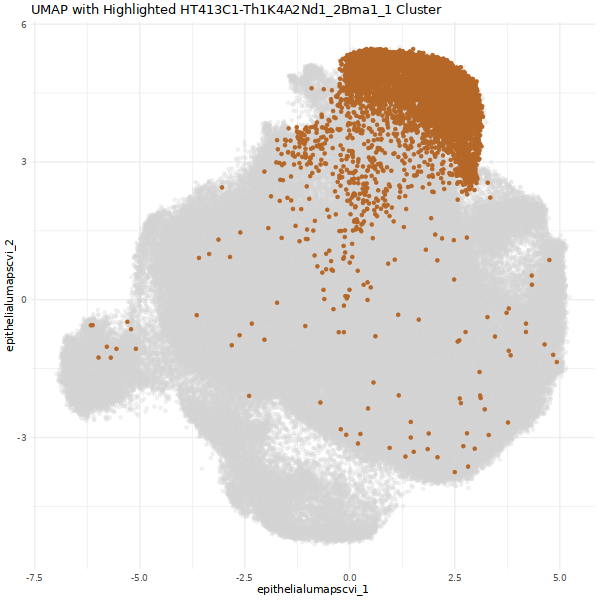

In [10]:
set_size(6,6)
Highlight_Cluster_UMAP(epithelial2, 
                       metadata_column='orig.ident', 
                       cell_type='HT413C1-Th1K4A2Nd1_2Bma1_1', 
                       umap_reduction = 'epithelial_umap.scvi')

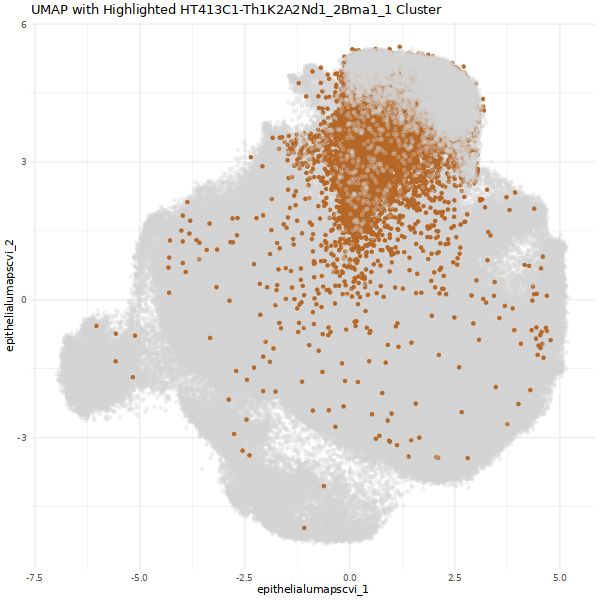

In [11]:
set_size(6,6)
Highlight_Cluster_UMAP(epithelial2, 
                       metadata_column='orig.ident', 
                       cell_type='HT413C1-Th1K2A2Nd1_2Bma1_1', 
                       umap_reduction = 'epithelial_umap.scvi')

In [ ]:
set_size(6,6)
FeaturePlot(tumor, features = 'SLC2A1', reduction = 'tumor_umap.scvi')

In [ ]:
#BEST4+ enterocytes (BEST4, OTOP2), 
#goblet cells (MUC2, TFF1, SYTL2), 
#immature goblet cells (KLK1, RETNLB, CLCA1), 
#stem cells (RGMB, SMOC2, LGR5, ASCL2), 
#tuft cells (SH2D6, TRPM5, BMX, LRMP, HCK), 
#enteroendocrine cells (SCGN, FEV, CHGA, PYY, GCG), 
#cycling transit-amplifying cells (TICRR, CDC25C),
#Paneth cells (LYZ, DEFA5)
# Nature volume 619, pages572–584 (2023)

# Post CPU SCVI integration 

## Epithelial subset analysis

### load object

In [18]:
setwd('/diskmnt/Projects/MetNet_analysis_2/Colorectal/snMultiome/rds_objects/cell_types_subset/epithelial')
epithelial = readRDS('57_Integrated_normalized_mCRC_snRNA_noDB_v7_epithelial_clean1_reINT.rds')
epithelial

An object of class Seurat 
71822 features across 234738 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 2 layers present: counts, data
 1 other assay present: SCT
 7 dimensional reductions calculated: pca, umap.rna, integrated.scvi, mCRCv4_umap.scvi, mCRCv5_umap.scvi, mCRCv6_umap.scvi, epithelial_umap.scvi

### re-clustering and annotation mapping

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



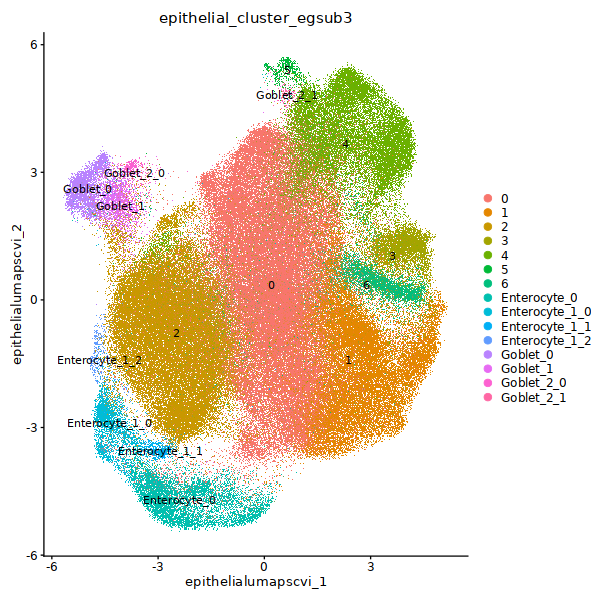

In [19]:
set_size(6,6)
DimPlot(epithelial, reduction = 'epithelial_umap.scvi', group.by = 'epithelial_cluster_egsub3', label = TRUE)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 234738
Number of edges: 3140894

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9424
Number of communities: 844
Elapsed time: 57 seconds


829 singletons identified. 15 final clusters.

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



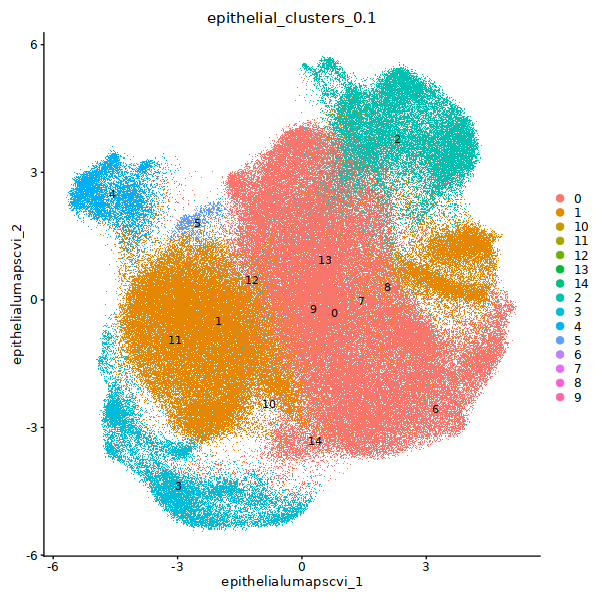

In [20]:
DefaultAssay(epithelial) = 'SCT'
epithelial <- FindClusters(epithelial, resolution = 0.1, cluster.name = 'epithelial_clusters_0.1', graph = 'RNA_snn')

set_size(6,6)
DimPlot(epithelial, reduction = 'epithelial_umap.scvi', group.by = 'epithelial_clusters_0.1', label = TRUE)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



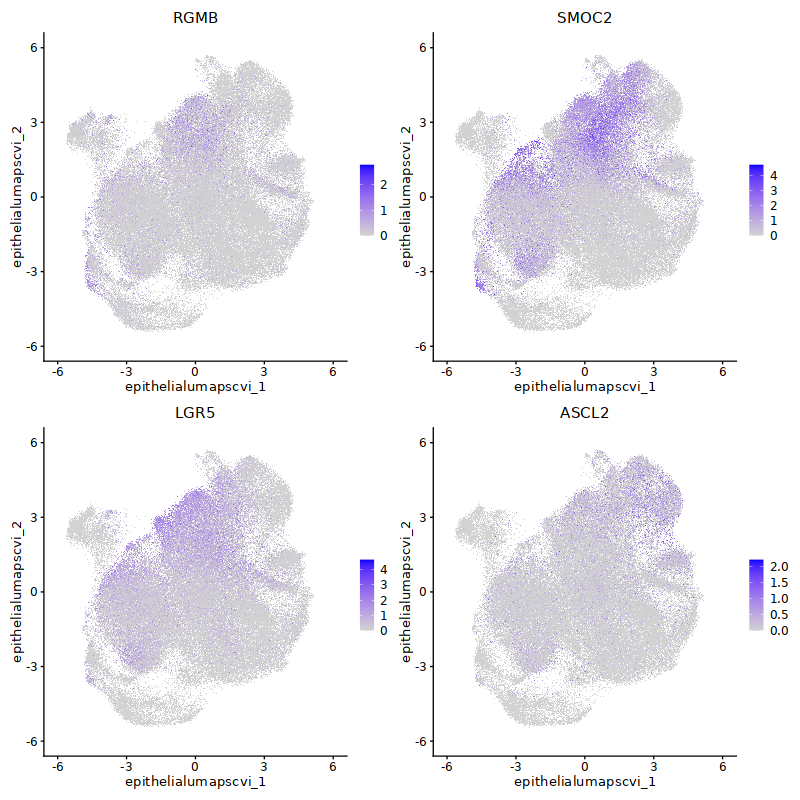

In [28]:
set_size(8,8)
FeaturePlot(epithelial, features = c('RGMB', 'SMOC2', 'LGR5', 'ASCL2'), reduction = 'epithelial_umap.scvi')

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



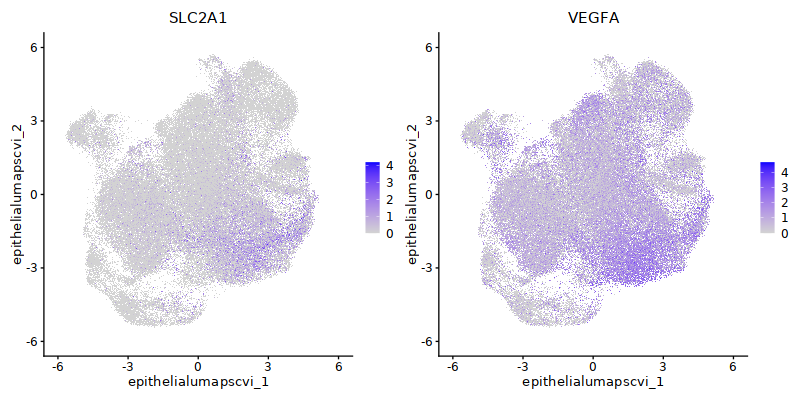

In [26]:
set_size(8,4)
DefaultAssay(epithelial) <- 'RNA'
FeaturePlot(epithelial, features = c('SLC2A1', 'VEGFA'), reduction = 'epithelial_umap.scvi')

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



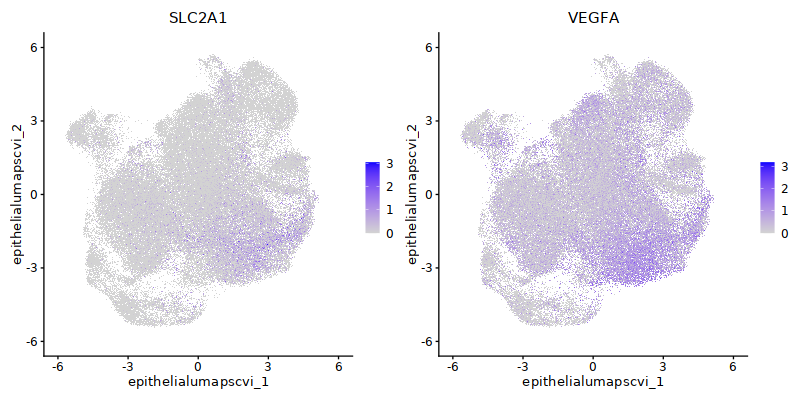

In [27]:
set_size(8,4)
DefaultAssay(epithelial) <- 'SCT'
FeaturePlot(epithelial, features = c('SLC2A1', 'VEGFA'), reduction = 'epithelial_umap.scvi')

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



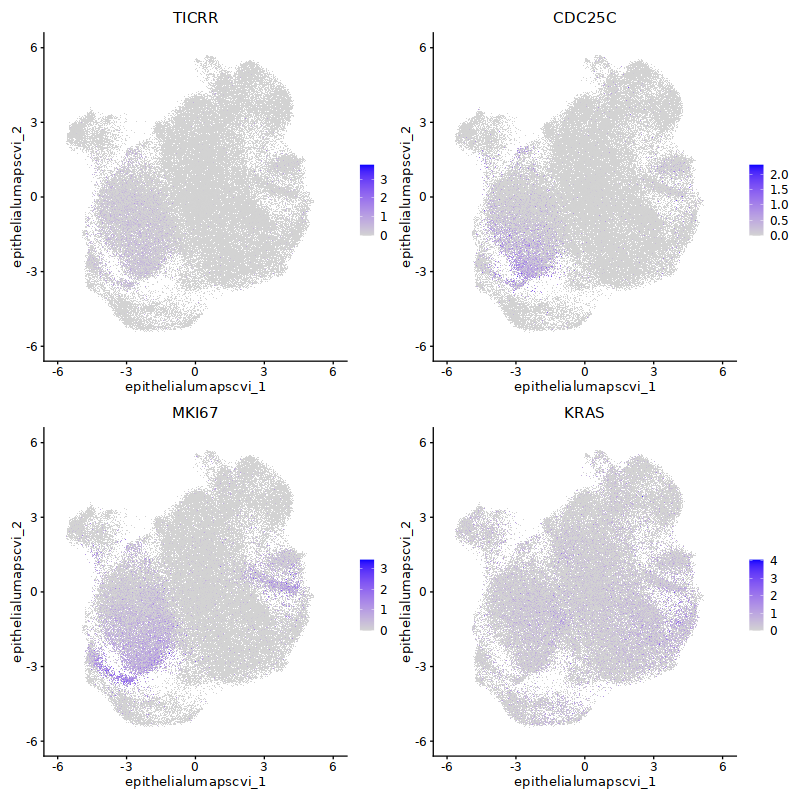

In [34]:
set_size(8,8)
FeaturePlot(epithelial, features = c('TICRR', 'CDC25C', 'MKI67', 'KRAS'), reduction = 'epithelial_umap.scvi')